In [ ]:
# species name

names = ['iSbBS512_1146', 'iSDY_1059', 'iSF_1195', 'iYL1228', 'iZ_1308', 'STM_v1_0']
name = names[3]

In [ ]:
!pip install biopython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re

def simplify_fasta(input_file, output_file):

    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    updated_lines = []
    sequence = ""
    gene_name = ""

    gene_pattern = re.compile(r"\[locus_tag=([^\]]+)\]")

    for line in lines:
        line = line.strip()
        if line.startswith(">"):

            if sequence:
                updated_lines.append(f">{gene_name}\n{sequence}\n")
                sequence = ""

            match = gene_pattern.search(line)
            if match:
                gene_name = match.group(1)
        else:

            sequence += line

    if sequence:
        updated_lines.append(f">{gene_name}\n{sequence}\n")

    with open(output_file, 'w') as outfile:
        outfile.writelines(updated_lines)

input_file = f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}.fasta'
output_file = f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_tag_seq.fasta'

simplify_fasta(input_file, output_file)

In [ ]:
from Bio import SeqIO

# read fasta
def read_fasta(file_path):
    gene_sequence_dict = {}

    # Extract fasta by SeqIO
    for record in SeqIO.parse(file_path, "fasta"):
        gene_name = record.id
        sequence = str(record.seq)
        gene_sequence_dict[gene_name] = sequence

    return gene_sequence_dict

# read fasta and write dic
file_path = f"/content/drive/MyDrive/Tripleknock/test_data_{name}/{name}.tag_seq.fasta"
gene_sequence_dict = read_fasta(file_path)

# print top items
for gene, sequence in list(gene_sequence_dict.items())[:5]:
    print(f"Gene: {gene}, Sequence: {sequence[:30]}...")

Gene: KPN_00001, Sequence: MNRIGMITTIITTTITTGNGAG...
Gene: KPN_00002, Sequence: MRVLKFGGTSVANAERFLRVADILESNARQ...
Gene: KPN_00003, Sequence: MVKVYAPASSANMSVGFDVLGAAVTPVDGT...
Gene: KPN_00004, Sequence: MKLYNLKDHNEQVSFAQAVTQGLGKHQGLF...
Gene: KPN_00005, Sequence: MVVFALTGCSGTTIGGNEDKLTPAYLKQHL...


In [ ]:
# gene number
num_genes = len(gene_sequence_dict)
print(f"Total number of genes: {num_genes}")

Total number of genes: 4776


In [ ]:
all_genes = set(list(gene_sequence_dict.keys()))

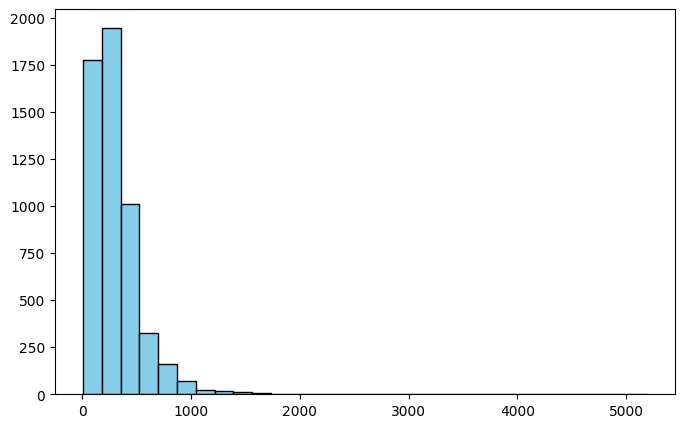

In [ ]:
import matplotlib.pyplot as plt

# gene legth
gene_lengths = [len(sequence) for sequence in gene_sequence_dict.values()]

# plot the distribution of gene length
plt.figure(figsize=(8, 5))
plt.hist(gene_lengths, bins=30, color='skyblue', edgecolor='black')
#plt.title('Gene Length Distribution')
#plt.xlabel('Gene Length')
#plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('iSbBS512_1146_4246', dpi=600)
plt.show()

In [ ]:
# define standard amino acids
standard_amino_acids = set('ACDEFGHIKLMNPQRSTVWY')

# check non-standard aa
def check_non_standard_amino_acids(sequence):
    return any(aa not in standard_amino_acids for aa in sequence)

# print genes that have non-standard aas
non_standard_count = 0
for gene, sequence in gene_sequence_dict.items():
    if check_non_standard_amino_acids(sequence):
        non_standard_count += 1
        print(gene, sequence)
        print('--------')

print(f"Number of genes containing non-standard amino acids: {non_standard_count}")

Number of genes containing non-standard amino acids: 0


In [ ]:
import numpy as np
from collections import Counter

# define all 2-mers
standard_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
all_2mers = [a + b for a in standard_amino_acids for b in standard_amino_acids]
two_mer_index = {two_mer: idx for idx, two_mer in enumerate(all_2mers)}

# 2-mer dict
two_mer_dict = {}

# for all genes and their sequences
for gene, sequence in gene_sequence_dict.items():
    # clean the sequence
    sequence = ''.join([aa for aa in sequence if aa in standard_amino_acids])

    # count 2-mers
    two_mer_counts = Counter([sequence[i:i+2] for i in range(len(sequence)-1)])

    # calculate the total number of 2-mers
    total_two_mers = sum(two_mer_counts.values())

    # initialize a vector
    feature_vector = np.zeros(400)

    # map 2-mer frequency
    for two_mer, count in two_mer_counts.items():
        if two_mer in two_mer_index:
            # frequency
            frequency = count / total_two_mers
            # frequency = count
            feature_vector[two_mer_index[two_mer]] = frequency

    # write the vector into the dict
    two_mer_dict[gene] = feature_vector

print(len(two_mer_dict))

# print top 5 2-mers
for gene, feature_vector in list(two_mer_dict.items())[:5]:
    print(f"Gene: {gene}")
    print(f"2-mer Feature Vector: {feature_vector}")

4776
Gene: KPN_00001
2-mer Feature Vector: [0.         0.         0.         0.         0.         0.04761905
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

In [ ]:
import torch
import numpy as np
import random
import torch.nn as nn

# Define the model
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),
            torch.nn.Linear(128, 3),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 400),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class Autoencoder2(torch.nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(4304, 3000),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(3000, 1000),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(1000, 400),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(400, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 3000),
            torch.nn.ReLU(),
            torch.nn.Linear(3000, 4304),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define MLP model class
class MLP(nn.Module):
    def __init__(self, input_size=2400, hidden_size1=512, hidden_size2=256, output_size=1, dropout_rate=0.1):  #######
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

# Load the models once
#device = torch.device("cpu")  # Use CPU as requested
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise use CPU

ae1 = Autoencoder()
ae1.to(device)

#ae1.load_state_dict(torch.load('/content/drive/MyDrive/Deepknock/model/ae1_all_data_training.pth', map_location=torch.device('cpu')))  # 加载训练好的模型
ae1.load_state_dict(torch.load('/content/drive/MyDrive/Tripleknock/Tripleknock_for_users/ae1_all_data_training.pth', map_location=device))

ae1.eval()

ae2 = Autoencoder2()
ae2.to(device)

#ae2.load_state_dict(torch.load('/content/drive/MyDrive/Deepknock/model/ae2_all_data_training.pth', map_location=torch.device('cpu')))  # 加载训练好的模型
ae2.load_state_dict(torch.load('/content/drive/MyDrive/Tripleknock/Tripleknock_for_users/ae2_all_data_training.pth', map_location=device))  # 加载训练好的模型

ae2.eval()

# Load the model and weights
mlp = MLP(input_size=2400).to(device)
mlp.load_state_dict(torch.load('/content/drive/MyDrive/Tripleknock/Tripleknock_for_users/mlp_all_data_10p.pth', map_location=device))
mlp.eval()  # Set the model to evaluation mode

def ae1_2(three_genes):
    rest_genes = list(all_genes - three_genes)
    inputs = np.vstack([two_mer_dict[gene] for gene in rest_genes]).astype(np.float32)
    #zeros_400 = np.zeros((2, 400), dtype=np.float32)
    #inputs = np.vstack([inputs, zeros_400])

    # target rows
    target_rows = 4304

    # current rows
    current_rows = inputs.shape[0]

    # align the number of rows
    if current_rows > target_rows:
        rows_to_delete = current_rows - target_rows
        inputs = inputs[:-rows_to_delete]  # delete rows

    # add zero rows
    elif current_rows < target_rows:
        rows_to_add = target_rows - current_rows
        zero_rows = np.zeros((rows_to_add, inputs.shape[1]), dtype=np.float32)
        inputs = np.vstack([inputs, zero_rows])

    # if no align rows need
    else:
        pass

    # print shapes for test
    #print(inputs.shape)

    inputs = torch.tensor(inputs).to(device)
    inputs = ae1.encoder(inputs)  # autoencoder1
    #print(inputs.shape)
    inputs = inputs.cpu().detach().numpy().T  # transpose for autoencoder2 input
    #print(inputs.shape)
    inputs = torch.tensor(inputs).to(device)
    outputs = ae2.encoder(inputs)  # autoencoder2 [3, 400] shape
    #print(outputs.shape)

    return outputs

def knockout(a,b,c):
    three_gene_features = np.array([two_mer_dict[gene] for gene in [a,b,c]])
    three_gene_features = three_gene_features.flatten()
    three_gene_features = (three_gene_features - np.mean(three_gene_features)) / (np.std(three_gene_features) + 1e-8)  # avoid divided by 0
    #print(three_gene_features)

    rest_gene_features = ae1_2({a,b,c}).detach().cpu().numpy()
    rest_gene_features = rest_gene_features.flatten()
    rest_gene_features = (rest_gene_features - np.mean(rest_gene_features)) / (np.std(rest_gene_features) + 1e-8)  # normalization and divided by 0
    #print(rest_gene_features)

    normalized_features = np.concatenate([three_gene_features, rest_gene_features])
    #print(normalized_features.shape)

    # Convert the input data to a PyTorch tensor
    input_tensor = torch.tensor(normalized_features, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

    # Make a prediction
    with torch.no_grad():  # Disable gradient calculation, since we are in inference mode
        output = mlp(input_tensor)  # Get model output
        #print(output)
        prediction = (output > 0.5).float()  # Convert output to binary (0 or 1)
        #prediction = output.float()

    # Output result
    #print(int(prediction.item()))

    #if int(prediction.item()) > 0.5:
      #print('knockout lethal: YES')

    #else:
      #print('knockout lethal: NO')

    return prediction.item()

three gene knockout FBA simulation

In [ ]:
! pip install cobra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 42.5 MB/s eta 0:00:00


In [ ]:
import cobra
model = cobra.io.read_sbml_model('/content/drive/MyDrive/Deepknock/test_data_iSDY_1059/iSDY_1059.xml')

In [ ]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.002263,0,0.00%
cl_e,EX_cl_e,0.002263,0,0.00%
cobalt2_e,EX_cobalt2_e,0.001509,0,0.00%
cu2_e,EX_cu2_e,0.001509,0,0.00%
fe2_e,EX_fe2_e,0.003502,0,0.00%
glc__D_e,EX_glc__D_e,5,6,100.00%
k_e,EX_k_e,0.08486,0,0.00%
mg2_e,EX_mg2_e,0.003772,0,0.00%
mn2_e,EX_mn2_e,0.001509,0,0.00%
mobd_e,EX_mobd_e,0.001509,0,0.00%


In [ ]:
import csv
gem_genes = {}
with open(f'/content/drive/MyDrive/Deepknock/test_data_{name}/' +f'{name}_1KO_growth', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        #print(len(row))
        if len(row) == 4:
            gem_genes[row[0]] = int(row[3])
    print(len(gem_genes))

print(gem_genes)

1270
{'STM0685': 0, 'STM1203': 0, 'STM4122': 1, 'STM1473': 0, 'STM2992': 1, 'STM0999': 0, 'STM3901': 0, 'STM3795': 0, 'STM3796': 0, 'STM3902': 0, 'STM2337': 0, 'STM3242': 0, 'STM2267': 0, 'STM0320': 0, 'STM2037': 0, 'STM0066': 0, 'STM0067': 0, 'STM1883': 0, 'STM3929': 0, 'STM3576': 0, 'STM1832': 0, 'STM0758': 0, 'STM4061': 0, 'STM3190': 1, 'STM4064': 0, 'STM4227': 0, 'STM4228': 0, 'STM4230': 0, 'STM4229': 0, 'STM4231': 0, 'STM4403': 0, 'STM1831': 0, 'STM1830': 0, 'STM3338': 0, 'STM3009': 0, 'STM3010': 0, 'STM1779': 0, 'STM3339': 0, 'STM0309': 0, 'STM1427': 0, 'STM3646': 0, 'STM1193': 0, 'STM4120': 1, 'STM1712': 0, 'STM0457': 0, 'STM2164': 0, 'STM0158': 0, 'STM2162': 0, 'STM2165': 0, 'STM2163': 0, 'STM1235': 0, 'STM3468': 1, 'STM0227': 0, 'STM1303': 0, 'STM1067': 1, 'STM2384': 1, 'STM2577': 0, 'STM3674': 0, 'STM3583': 0, 'STM4233': 0, 'STM2645': 0, 'STM2927': 0, 'STM0623': 0, 'STM1517': 0, 'STM1195': 1, 'STM4273': 0, 'STM2378': 1, 'STM0060': 0, 'STM0061': 0, 'STM1197': 1, 'STM1463': 0, 

In [ ]:
all_genes

In [ ]:
intersectiongenes = gem_genes.keys() & all_genes
print(len(intersectiongenes))

1250


In [ ]:
import random
import csv

# select 20,000 combinations randomly
selected_combinations = []

for _ in range(20000):
    # combine genes
    combination = random.sample(list(intersectiongenes), 3)
    selected_combinations.append(combination)

# save the results as csv
with open(f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_gene_combinations_1.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(selected_combinations)

print("CSV saved")

CSV 文件已保存


In [ ]:
import csv

# create a list for saving gene sets
gene_combinations_list = []

# read csv
with open(f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_gene_combinations_3.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        # convert genes in each row to a set
        gene_combination_list = list(row)
        gene_combinations_list.append(gene_combination_list)

# print results
print(gene_combinations_list[:10])

[['STM3254', 'STM4230', 'STM2577'], ['STM0423', 'STM3635', 'STM1288'], ['STM1477', 'STM2573', 'STM3051'], ['STM4037', 'STM1726', 'STM4130'], ['STM3244', 'STM2460', 'STM1099'], ['STM3205', 'STM1259', 'STM1433'], ['STM1570', 'STM4484', 'STM3554'], ['STM4062', 'STM1307', 'STM2033'], ['STM0321', 'STM2863', 'STM3255'], ['STM0056', 'STM3564', 'STM1954']]


In [ ]:
! pip install tqdm

In [ ]:
from tqdm import tqdm
import cobra

with open('/content/drive/MyDrive/Deepknock/test_data_STM_v1_0/STM_v1_0_3KO_fba_1.csv', mode='a', newline='') as csvfile:
    writer = csv.writer(csvfile)

    initial_state = cobra.flux_analysis.pfba(model)
    initial_growth = round(initial_state.fluxes['BIOMASS_iRR1083_metals'], 3)

    for gene in tqdm(gene_combinations_list):
        with model:
            try:
                model.genes.get_by_id(gene[0]).knock_out()
                model.genes.get_by_id(gene[1]).knock_out()
                model.genes.get_by_id(gene[2]).knock_out()
                altered_state = cobra.flux_analysis.pfba(model)
                altered_growth = round(altered_state.fluxes['BIOMASS_iRR1083_metals'], 3)
                label = 1 if altered_growth < 0.1 * initial_growth else 0
                writer.writerow([gene[0], gene[1], gene[2], label])
            except Exception as e:
                writer.writerow(['Failed', str(e)])

 69%|██████▉   | 13875/20000 [1:26:15<46:58,  2.17it/s]

In [ ]:
# for STM_v1_0
gene_combinations_list[13874]
# ['STM4081', 'STM1225', 'STM3629']
# actually, the file generate to 12768/20000

['STM4081', 'STM1225', 'STM3629']

In [ ]:
from tqdm import tqdm

with open(f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_3KO_deepknock_10p_3.csv', mode='a', newline='') as csvfile:
    writer = csv.writer(csvfile)

    for gene in tqdm(gene_combinations_list):

          writer.writerow([gene[0], gene[1], gene[2], knockout(gene[0], gene[1], gene[2])])


100%|██████████| 20000/20000 [03:41<00:00, 90.27it/s]


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# read data
deepknock_file = f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_3KO_deepknock_10p_3.csv'
fba_file = f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_3KO_fba_3.csv'

deepknock_data = pd.read_csv(deepknock_file)
fba_data = pd.read_csv(fba_file)

# the last row as labels
deepknock_labels = deepknock_data.iloc[:, -1]  # prediction labels
fba_labels = fba_data.iloc[:, -1]  # real labels

# this code, is when process STM_v1_0, number2, some gene knockout stuck so I just select the top result to analyze
#deepknock_labels = deepknock_labels[:12000]
#fba_labels = fba_labels[:12000]

# delete Nan rows
valid_indices = deepknock_labels.notna() & fba_labels.notna()  # search for not NaN rows
deepknock_labels = deepknock_labels[valid_indices]
fba_labels = fba_labels[valid_indices]

# calclate evalation
accuracy_deepknock = accuracy_score(fba_labels, deepknock_labels)
precision_deepknock = precision_score(fba_labels, deepknock_labels)
recall_deepknock = recall_score(fba_labels, deepknock_labels)
f1_deepknock = f1_score(fba_labels, deepknock_labels)
conf_matrix_deepknock = confusion_matrix(fba_labels, deepknock_labels)

# print reuslts
print(f'{name}_10%_3')
print('-------------')
print(f"Deepknock Accuracy: {accuracy_deepknock:.2f}")
print(f"Deepknock Precision: {precision_deepknock:.2f}")
print(f"Deepknock Recall: {recall_deepknock:.2f}")
print(f"Deepknock F1 Score: {f1_deepknock:.2f}")
print(f"Deepknock Confusion Matrix: {conf_matrix_deepknock}")

STM_v1_0_10%_3
-------------
Deepknock Accuracy: 0.73
Deepknock Precision: 0.65
Deepknock Recall: 0.70
Deepknock F1 Score: 0.68
Deepknock Confusion Matrix: [[8856 3017]
 [2440 5673]]


## **Model** **interpretability** revised on 20260204

#### PART-0 feature calculation by Tripleknock and label by FBA data

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# read csv
df = pd.read_csv(f'/content/drive/MyDrive/Deepknock/test_data_{name}/{name}_3KO_fba_1.csv', header=None)

# create a list for features and labels
features = []
labels = []

# show tqdm
for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):

    # skip rows
    if 'Failed' in row.values:
        continue

    # get genes
    a, b, c = row[0], row[1], row[2]

    # calculate 2-mer features
    three_gene_features = np.array([two_mer_dict[gene] for gene in [a, b, c]])
    three_gene_features = three_gene_features.flatten()

    # calculate genome features
    rest_gene_features = ae1_2({a, b, c}).detach().cpu().numpy()
    rest_gene_features = rest_gene_features.flatten()

    # combined features
    all_features = np.concatenate([three_gene_features, rest_gene_features])

    # get labels
    label = row[3]

    # add features and label
    features.append(all_features)
    labels.append(label)

# to DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

# new CSV
features_df.to_csv(f'/content/drive/MyDrive/Deepknock/Interpretability/original_features_{name}.csv', index=False)

print("saved 'original_features_iSDY_1059.csv'")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 1.1 read data
file_path = f'/content/drive/MyDrive/Tripleknock/Interpretability/original_features_{name}.csv'
df = pd.read_csv(file_path)

print('Data shape:', df.shape)  #should be (20000, 2401)

# 1.2 features and labels
feature_cols = [col for col in df.columns if col != 'label']
X = df[feature_cols]
y = df['label']

Data shape: (20000, 2401)


第一行（a–c）：火山图（只做 data separability，不再说 feature importance）

第二行（d–f）：IG 的 block-level 贡献（KO 3×400 + AE 1200）

第三行（g–i）：用 IG 排名做你原来的 “前1200占比 enrichment 曲线”（替代原来按 p 值排名）

In [ ]:
## =========================
## Cell A. Load raw original features + apply the SAME normalization as training (single species)
## - Input : original_features_{name}.csv (raw concatenated features + label)
## - Output:
##   X_raw: (N,2400) raw
##   Xn   : (N,2400) normalized like training
##   y    : (N,)
## - Key : block-wise per-sample z-score
##         - first 1200 dims: KO 2-mer block (all 3 genes together)
##         - last  1200 dims: AE block
## =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import torch
from sklearn.metrics import roc_auc_score

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10
})

FEATURE_DIR = "/content/drive/MyDrive/Tripleknock/Interpretability"
FIG_DIR = "/content/drive/MyDrive/Tripleknock/Interpretability—_REVISED_result_20260204/Fig3"  # need save -> uncomment later

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_original_features(name: str):
    fp = os.path.join(FEATURE_DIR, f"original_features_{name}.csv")
    df = pd.read_csv(fp)
    feature_cols = [c for c in df.columns if c != "label"]
    X_raw = df[feature_cols].values.astype(np.float32)
    y = df["label"].values.astype(int)
    return X_raw, y, df

def zscore_per_row(M: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """
    Row-wise z-score normalization.
    Each row is normalized by its own mean/std.
    """
    mu = M.mean(axis=1, keepdims=True)
    sd = M.std(axis=1, keepdims=True)
    return (M - mu) / (sd + eps)

def normalize_like_training(X_raw: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """
    Match your training-time normalization:
      - z-score within KO block (first 1200 dims) per sample
      - z-score within AE block (last 1200 dims) per sample
      - concat (no extra scaling unless your training had it)
    """
    ko = X_raw[:, :1200].astype(np.float32)
    ae = X_raw[:, 1200:].astype(np.float32)

    ko_n = zscore_per_row(ko, eps=eps).astype(np.float32)
    ae_n = zscore_per_row(ae, eps=eps).astype(np.float32)

    return np.concatenate([ko_n, ae_n], axis=1).astype(np.float32)

def print_scale_report(tag: str, X: np.ndarray):
    ko = X[:, :1200]
    ae = X[:, 1200:]
    print(f"\n[{tag}] mean|KO|={np.mean(np.abs(ko)):.6f}  std(KO)={np.std(ko):.6f}")
    print(f"[{tag}] mean|AE|={np.mean(np.abs(ae)):.6f}  std(AE)={np.std(ae):.6f}")
    print(f"[{tag}] median per-sample mean|KO|={np.median(np.mean(np.abs(ko), axis=1)):.6f}")
    print(f"[{tag}] median per-sample mean|AE|={np.median(np.mean(np.abs(ae), axis=1)):.6f}")

def block_importance(importance: np.ndarray) -> dict:
    return {
        "KO1(1-400)": float(importance[0:400].sum()),
        "KO2(401-800)": float(importance[400:800].sum()),
        "KO3(801-1200)": float(importance[800:1200].sum()),
        "AE(1201-2400)": float(importance[1200:2400].sum()),
    }

def ig_enrichment_curve(importance: np.ndarray, mid_point: int = 1200):
    ranked = np.argsort(-importance)
    ks = np.arange(1, len(ranked) + 1)
    is_ko = (ranked < mid_point).astype(int)
    prop = np.cumsum(is_ko) / ks
    return ks, prop

def plot_block_bar(ax, blk: dict, title: str):
    keys = list(blk.keys())
    vals = np.array(list(blk.values()), dtype=float)
    vals = vals / (vals.sum() + 1e-12)
    ax.bar(np.arange(len(keys)), vals, width=0.7)
    ax.set_xticks(np.arange(len(keys)))
    ax.set_xticklabels(keys, rotation=25, ha="right")
    ax.set_ylabel("Attribution proportion")
    ax.set_title(title)
    ax.set_ylim(0, max(vals) * 1.15)

def plot_enrichment(ax, ks, prop, title: str):
    ax.plot(ks, prop, linewidth=1.6)
    ax.set_ylim(0, 1.0)
    ax.set_title(title)
    ax.set_xlabel("Top feature rank (by IG)")
    ax.set_ylabel("Proportion from KO block (1–1200)")

## ---- choose species here ----
#name = "iYL1228"  # you change

X_raw, y, df_raw = load_original_features(name)
Xn = normalize_like_training(X_raw)

print("Loaded:", name, "| shape:", X_raw.shape, "| pos:", int((y==1).sum()), "| neg:", int((y==0).sum()))
print_scale_report("RAW", X_raw)
print_scale_report("NORM", Xn)


Loaded: iYL1228 | shape: (20000, 2400) | pos: 5283 | neg: 14717

[RAW] mean|KO|=0.002500  std(KO)=0.003661
[RAW] mean|AE|=0.691956  std(AE)=0.978020
[RAW] median per-sample mean|KO|=0.002500
[RAW] median per-sample mean|AE|=0.691752

[NORM] mean|KO|=0.737822  std(KO)=0.999997
[NORM] mean|AE|=0.705898  std(AE)=1.000000
[NORM] median per-sample mean|KO|=0.741664
[NORM] median per-sample mean|AE|=0.706291


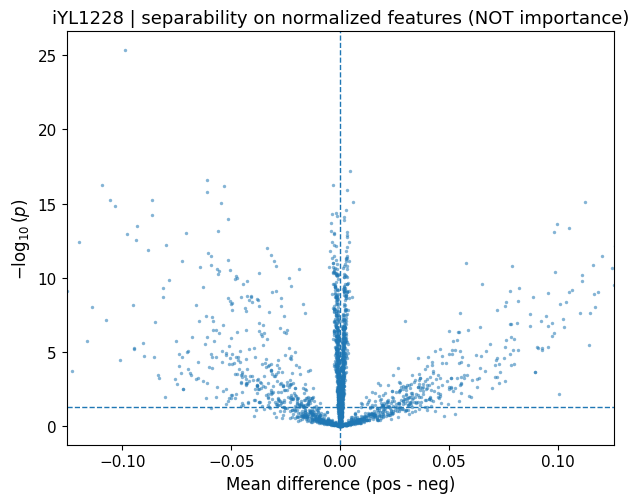

In [ ]:
## =========================
## Cell B. Part (i) Data structure / class separability analysis (single species)
## - Volcano plot on NORMALIZED features (Xn) for fair comparison across blocks
## - Still: descriptive separability, NOT model importance
## =========================

def compute_volcano_stats(X: np.ndarray, y: np.ndarray) -> pd.DataFrame:
    X_pos = X[y == 1]
    X_neg = X[y == 0]

    mean_pos = X_pos.mean(axis=0)
    mean_neg = X_neg.mean(axis=0)
    mean_diff = mean_pos - mean_neg

    t_res = ttest_ind(X_pos, X_neg, axis=0, equal_var=False, nan_policy="omit")
    p = t_res.pvalue
    p = np.where(p <= 1e-300, 1e-300, p)
    neg_log10_p = -np.log10(p)

    return pd.DataFrame({
        "feature_idx": np.arange(1, X.shape[1] + 1),
        "mean_diff": mean_diff,
        "p_value": p,
        "neg_log10_p": neg_log10_p
    })

def plot_volcano(ax, stats: pd.DataFrame, title: str):
    ax.scatter(stats["mean_diff"], stats["neg_log10_p"], s=6, alpha=0.55, linewidths=0)
    ax.axvline(0.0, linestyle="--", linewidth=1)
    ax.axhline(-np.log10(0.05), linestyle="--", linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("Mean difference (pos - neg)")
    ax.set_ylabel(r"$-\log_{10}(p)$")

    x = stats["mean_diff"].values
    xlim = np.percentile(np.abs(x), 99)
    if xlim > 0:
        ax.set_xlim(-xlim, xlim)

stats_n = compute_volcano_stats(Xn, y)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 5.2))
plot_volcano(ax, stats_n, title=f"{name} | separability on normalized features (NOT importance)")
plt.tight_layout()
plt.show()

# save if needed
os.makedirs(FIG_DIR, exist_ok=True)
fig.savefig(os.path.join(FIG_DIR, f"{name}_volcano_separability_norm.png"), dpi=600, bbox_inches="tight")


IG block importance (logit-attribution): {'KO1(1-400)': 61.026893615722656, 'KO2(401-800)': 38.02156448364258, 'KO3(801-1200)': 59.4931755065918, 'AE(1201-2400)': 0.2883261442184448}


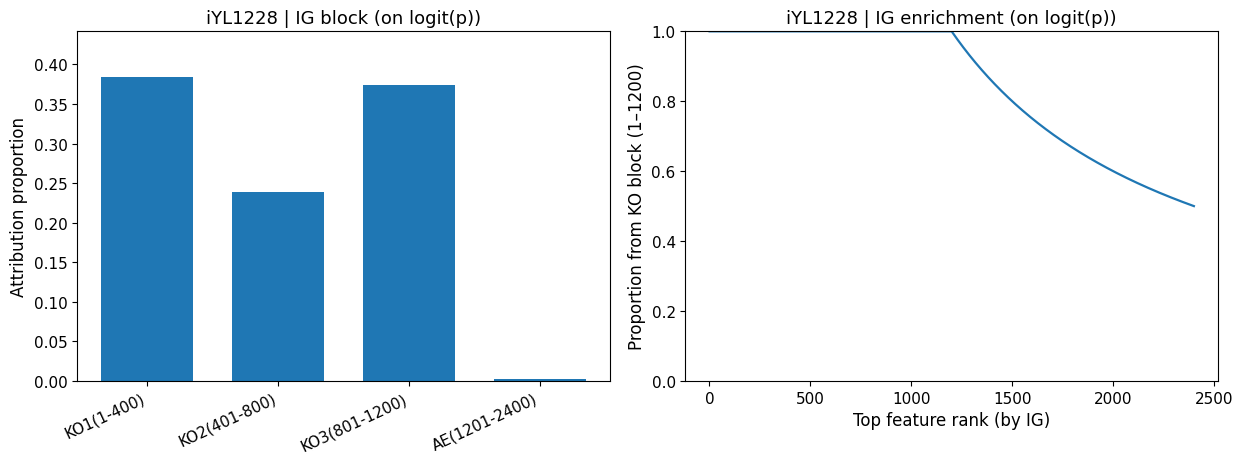

In [ ]:
## =========================
## Cell C. IG attribution on logit(p) to avoid sigmoid saturation
## - Your model outputs probability p in (0,1)
## - We attribute on logit(p) = log(p/(1-p)) for stable gradients
## =========================

def block_importance(importance: np.ndarray) -> dict:
    return {
        "KO1(1-400)": float(importance[0:400].sum()),
        "KO2(401-800)": float(importance[400:800].sum()),
        "KO3(801-1200)": float(importance[800:1200].sum()),
        "AE(1201-2400)": float(importance[1200:2400].sum()),
    }


def integrated_gradients_global_importance_logit(
    model: torch.nn.Module,
    X: np.ndarray,
    device: torch.device,
    steps: int = 20,
    n_samples: int = 2000,
    batch_size: int = 128,
    baseline: str = "mean",
    seed: int = 0,
    clamp_eps: float = 1e-6,
) -> np.ndarray:

    rng = np.random.default_rng(seed)
    n = min(n_samples, len(X))
    idx = rng.choice(len(X), size=n, replace=False)

    X_sub = torch.tensor(X[idx], dtype=torch.float32, device=device)

    if baseline == "zero":
        X0 = torch.zeros_like(X_sub)
    elif baseline == "mean":
        mu = X_sub.mean(dim=0, keepdim=True)
        X0 = mu.repeat(X_sub.shape[0], 1)
    else:
        raise ValueError("baseline must be 'zero' or 'mean'")

    model.eval()
    model.to(device)

    abs_sum = torch.zeros(X_sub.shape[1], device=device)

    for start in range(0, X_sub.shape[0], batch_size):
        xb = X_sub[start:start+batch_size]
        x0b = X0[start:start+batch_size]

        grads_sum = torch.zeros_like(xb)

        for s in range(1, steps + 1):
            alpha = float(s) / steps
            xsb = (x0b + alpha * (xb - x0b)).detach()
            xsb.requires_grad_(True)

            # model output is probability p
            p = model(xsb).squeeze(-1)

            # convert to logit for stable attribution
            p = p.clamp(clamp_eps, 1.0 - clamp_eps)
            out = torch.log(p / (1.0 - p))  # logit(p)

            out.sum().backward()

            grads_sum += xsb.grad.detach()
            model.zero_grad(set_to_none=True)

        avg_grads = grads_sum / steps
        ig = (xb - x0b) * avg_grads
        abs_sum += ig.abs().sum(dim=0)

    importance = (abs_sum / X_sub.shape[0]).detach().cpu().numpy()
    return importance

# ---- run IG on normalized Xn ----
device = get_device()

importance = integrated_gradients_global_importance_logit(
    model=mlp,
    X=Xn,
    device=device,
    steps=20,
    n_samples=2000,
    batch_size=128,
    baseline="mean",
    seed=0
)

blk = block_importance(importance)
print("IG block importance (logit-attribution):", blk)

ks, prop = ig_enrichment_curve(importance, mid_point=1200)

fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.8))
plot_block_bar(axes[0], blk, title=f"{name} | IG block (on logit(p))")
plot_enrichment(axes[1], ks, prop, title=f"{name} | IG enrichment (on logit(p))")
plt.tight_layout()
plt.show()

fig.savefig(os.path.join(FIG_DIR, f"{name}_Attribution.png"), dpi=600, bbox_inches="tight")


,group,base_auc,mean_auc_drop,std_auc_drop
1,KO2(401-800),0.737793,0.105448,0.003234
2,KO3(801-1200),0.737793,0.073175,0.001298
0,KO1(1-400),0.737793,0.071437,0.001162
3,AE(1201-2400),0.737793,-0.000199,0.000053


/tmp/ipython-input-3235218883.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(perm_df["group"], rotation=25, ha="right")


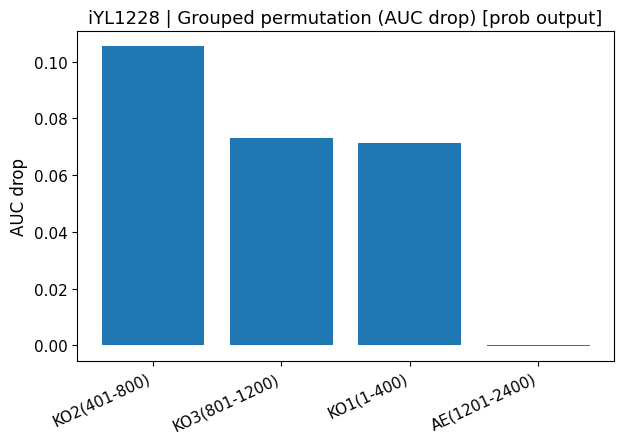

In [ ]:
## =========================
## Cell D. Grouped permutation importance (AUC drop) on PROB output
## - Your mlp.forward returns probability already -> apply_sigmoid=False
## =========================

from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

## Define feature blocks for grouped permutation
groups = {
    "KO1(1-400)": (0, 400),
    "KO2(401-800)": (400, 800),
    "KO3(801-1200)": (800, 1200),
    "AE(1201-2400)": (1200, 2400),
}

def grouped_permutation_importance_auc(
    model,
    X: np.ndarray,
    y: np.ndarray,
    device: torch.device,
    groups: dict,
    n_repeats: int = 5,
    seed: int = 0,
    apply_sigmoid: bool = False,
    batch_size: int = 512
) -> pd.DataFrame:
    """
    Grouped permutation importance measured by AUC drop.
    """
    rng = np.random.default_rng(seed)

    base_prob = predict_proba_numpy(model, X, device=device, batch_size=batch_size, apply_sigmoid=apply_sigmoid)
    base_auc = roc_auc_score(y, base_prob)

    rows = []
    for gname, (a, b) in groups.items():
        drops = []
        for _ in range(n_repeats):
            Xp = X.copy()
            perm_idx = rng.permutation(len(Xp))
            Xp[:, a:b] = Xp[perm_idx, a:b]

            prob_p = predict_proba_numpy(model, Xp, device=device, batch_size=batch_size, apply_sigmoid=apply_sigmoid)
            auc_p = roc_auc_score(y, prob_p)
            drops.append(base_auc - auc_p)

        rows.append({
            "group": gname,
            "base_auc": float(base_auc),
            "mean_auc_drop": float(np.mean(drops)),
            "std_auc_drop": float(np.std(drops))
        })

    return pd.DataFrame(rows).sort_values("mean_auc_drop", ascending=False)


def predict_proba_numpy(model, X_np: np.ndarray, device: torch.device, batch_size: int = 512, apply_sigmoid: bool = False) -> np.ndarray:
    """
    If model outputs probability already -> apply_sigmoid=False (recommended for your MLP)
    If model outputs logits -> apply_sigmoid=True
    """
    model.eval()
    model.to(device)
    probs = []
    with torch.no_grad():
        for i in range(0, len(X_np), batch_size):
            xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32, device=device)
            out = model(xb).squeeze(-1)
            if apply_sigmoid:
                out = torch.sigmoid(out)
            probs.append(out.detach().cpu().numpy())
    return np.concatenate(probs)


perm_df = grouped_permutation_importance_auc(
    model=mlp,
    X=Xn,
    y=y,
    device=device,
    groups=groups,
    n_repeats=5,
    seed=0,
    apply_sigmoid=False  # <--- IMPORTANT
)

display(perm_df)

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.6))
ax.bar(perm_df["group"], perm_df["mean_auc_drop"])
ax.set_title(f"{name} | Grouped permutation (AUC drop) [prob output]")
ax.set_ylabel("AUC drop")
ax.set_xticklabels(perm_df["group"], rotation=25, ha="right")
plt.tight_layout()
plt.show()
